## Multilayer perceptron. Stochastic gradient descent


### Класс перцептрона
Вход            -   столбец $ W_{in} \;[ 784 \times 1] $, $ 784 = 28 \times 28 $ -- размер исходного изображения  
Первый слой     -   столбец $ S_{1} \; [16 \times 1] $  
Второй слой     -   столбец $ S_{2} \; [10 \times 1] $  
Выходной слой   -   столбец $ W_{out} \; [10 \times 1] $  
В выходном слое в элементе $W_{out}[i], i \in [0,9]$ содержится оценка вероятности того, что на вход подано изображение числа $i$  
В качестве функции активации используется сигмоида $\sigma (x) = \frac{1}{1 + e^{-x}}$  

In [23]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle


class Perceptron:
    # INFO
    # Matrix sizes

    # s_in:  [w_in_dim  x 1        ]
    # w_1:   [w_1_dim   x w_in_dim ]
    # w_2:   [w_2_dim   x w_1_dim  ]
    # w_3:   [w_out_dim x w_2_dim  ]
    # s_out: [w_out_dim x 1        ]

    s_in_dim = 0  # size of input vector
    w_1_dim = 0  # number of rows in 1st hidden layer
    w_2_dim = 0  # number of rows in 2nd hidden layer
    s_out_dim = 0  # size of output vector

    layers = []  # [w_1, w_2, w_3]
    w_1 = []  # matrix with coefficients in ->  1
    w_2 = []  # matrix with coefficients 1  ->  2
    w_3 = []  # matrix with coefficients 2  ->  out

    delta_w_1 = []
    delta_w_2 = []
    delta_w_3 = []

    eta = 0
    test_num = 0  # 0 in the beginning of learning. Increases when picture is processed
    epoch_num = 0  # 0 in the beginning of learning. Increases when the whole battery of test pictures is processed

    error = []  # array of errors of all the tests

    def act_func(self, x):
        return 1 / (1 + np.exp(-x))

    def __init__(self, s_in_dim, w_1_dim, w_2_dim, s_out_dim, is_continuation):
        if is_continuation:
            self.load_changes()
        else:
            self.s_in_dim = s_in_dim
            self.w_1_dim = w_1_dim
            self.w_2_dim = w_2_dim
            self.s_out_dim = s_out_dim

            self.w_1 = np.random.sample((w_1_dim, s_in_dim)) / 10000
            self.w_2 = np.random.sample((w_2_dim, w_1_dim)) / 100
            self.w_3 = np.random.sample((s_out_dim, w_2_dim)) / 10

            self.delta_w_1 = np.zeros((w_1_dim, s_in_dim))
            self.delta_w_2 = np.zeros((w_2_dim, w_1_dim))
            self.delta_w_3 = np.zeros((s_out_dim, w_2_dim))

            self.layers = [self.w_1, self.w_2, self.w_3]

    def recognize(self, picture):
        s_1 = self.act_func(self.w_1 @ picture)
        s_2 = self.act_func(self.w_2 @ s_1)
        s_out = self.act_func(self.w_3 @ s_2)
        return np.argmax(s_out)

    def get_output(self, picture):
        picture = np.array(picture).reshape((len(picture), 1)) / 255
        s_1 = self.act_func(self.w_1 @ picture)
        s_2 = self.act_func(self.w_2 @ s_1)
        s_out = self.act_func(self.w_3 @ s_2)
        return s_out

    def errf(self, picture, ans):
        picture = np.array(picture).reshape((len(picture), 1)) / 255
        s_1 = self.act_func(self.w_1 @ picture)
        s_2 = self.act_func(self.w_2 @ s_1)
        s_out = self.act_func(self.w_3 @ s_2)

        indicators = np.zeros(self.s_out_dim)
        indicators[ans] = 1

        return np.linalg.norm(indicators - s_out) / 2

    def errf_with_custom_weights(self, picture, ans, w_1, w_2, w_3):
        picture = np.array(picture).reshape((len(picture), 1)) / 255
        s_1 = self.act_func(w_1 @ picture)
        s_2 = self.act_func(w_2 @ s_1)
        s_out = self.act_func(w_3 @ s_2)

        indicators = np.zeros(self.s_out_dim)
        indicators[ans] = 1

        return np.linalg.norm(indicators - s_out) / 2

    def get_grad(self, picture, ans):
        picture = np.array(picture).reshape((len(picture), 1)) / 255
        s_1 = self.act_func(self.w_1 @ picture)
        s_2 = self.act_func(self.w_2 @ s_1)
        s_out = self.act_func(self.w_3 @ s_2)

        indicators = np.zeros(self.s_out_dim)
        indicators[ans] = 1

        delta_3 = s_out * (s_out - np.ones(self.s_out_dim).reshape((self.s_out_dim, 1))) * (
                indicators.reshape((self.s_out_dim, 1)) - s_out)
        delta_2 = s_2 * (np.ones(len(s_2)).reshape((len(s_2), 1)) - s_2) * (self.w_3.T @ delta_3)
        delta_1 = s_1 * (np.ones(len(s_1)).reshape((len(s_1), 1)) - s_1) * (self.w_2.T @ delta_2)

        grad_w_3 = (s_2.reshape((self.w_2_dim, 1)) @ delta_3.reshape((1, self.s_out_dim))).T
        grad_w_2 = (self.eta * s_1.reshape((self.w_1_dim, 1)) @ delta_2.reshape((1, self.w_2_dim))).T
        grad_w_1 = (self.eta * picture @ delta_1.reshape((1, self.w_1_dim))).T

        return grad_w_1, grad_w_2, grad_w_3

    def back_propagation(self, picture, ans, alpha):
        picture = np.array(picture).reshape((len(picture), 1)) / 255
        s_1 = self.act_func(self.w_1 @ picture)
        s_2 = self.act_func(self.w_2 @ s_1)
        s_out = self.act_func(self.w_3 @ s_2)

        indicators = np.zeros(self.s_out_dim)
        indicators[ans] = 1

        delta_3 = s_out * (s_out - np.ones(self.s_out_dim).reshape((self.s_out_dim, 1))) * (
                indicators.reshape((self.s_out_dim, 1)) - s_out)
        delta_2 = s_2 * (np.ones(len(s_2)).reshape((len(s_2), 1)) - s_2) * (self.w_3.T @ delta_3)
        delta_1 = s_1 * (np.ones(len(s_1)).reshape((len(s_1), 1)) - s_1) * (self.w_2.T @ delta_2)

        self.delta_w_3 = alpha * self.delta_w_3 + \
                         ((1 - alpha) * self.eta * s_2.reshape((self.w_2_dim, 1)) @ delta_3.reshape(
                             (1, self.s_out_dim))).T
        self.delta_w_2 = alpha * self.delta_w_2 + \
                         ((1 - alpha) * self.eta * s_1.reshape((self.w_1_dim, 1)) @ delta_2.reshape(
                             (1, self.w_2_dim))).T
        self.delta_w_1 = alpha * self.delta_w_1 + \
                         ((1 - alpha) * self.eta * picture @ delta_1.reshape((1, self.w_1_dim))).T

        self.w_3 -= self.delta_w_3
        self.w_2 -= self.delta_w_2
        self.w_1 -= self.delta_w_1

        self.error.append(np.linalg.norm(indicators - s_out) / 2)

    def get_data(self):
        with open("perceptron_data.json", "r") as read_file:
            data = json.load(read_file)
            # update data
            data["s_in_dim"] = Perceptron.s_in_dim
            data["w_1_dim"] = Perceptron.w_1_dim
            data["w_2_dim"] = Perceptron.w_2_dim
            data["s_out_dim"] = Perceptron.s_out_dim
            data["layers"] = Perceptron.layers
            data["w_1"] = Perceptron.w_1
            data["w_2"] = Perceptron.w_2
            data["w_3"] = Perceptron.w_3
            data["delta_w_1"] = Perceptron.delta_w_1
            data["delta_w_2"] = Perceptron.delta_w_2
            data["delta_w_3"] = Perceptron.delta_w_3
            data["eta"] = Perceptron.eta
            data["test_num"] = Perceptron.test_num
            data["epoch_num"] = Perceptron.epoch_num
            data["error"] = Perceptron.error
        return data

    
    def initial_state():
        initial_state_dict = {
        "s_in_dim": 0,
        "w_1_dim": 0,
        "w_2_dim": 0,
        "s_out_dim": 0,
        "layers": [],
        "w_1": [],
        "w_2": [],
        "w_3": [],
        "delta_w_1": [],
        "delta_w_2": [],
        "delta_w_3": [],
        "eta": 0,
        "test_num": 0,
        "epoch_num": 0,
        "error": []
        }
        return initial_state_dict
    
    
    def save_state(self):
        if os.path.exists("perceptron_data.json"):
            data = get_data(self)
            with open("data_file4.json", "w") as write_file:
                write_file.write(json.dumps(data))
        else:
            with open("perceptron_data.json", "w") as write_file:
                write_file.write(json.dumps(initial_state))
            data = get_data(self)
            with open("data_file4.json", "w") as write_file:
                write_file.write(json.dumps(data))


    def load_state(self):
        with open("data_file4.json", "r") as read_file:
            data = json.load(read_file)
            Perceptron.s_in_dim = data["s_in_dim"]
            Perceptron.w_1_dim = data["w_1_dim"]
            Perceptron.w_2_dim = data["w_2_dim"]
            Perceptron.s_out_dim = data["s_out_dim"]
            Perceptron.layers = data["layers"]
            Perceptron.w_1 = data["w_1"]
            Perceptron.w_2 = data["w_2"]
            Perceptron.w_3 = data["w_3"]
            Perceptron.delta_w_1 = data["delta_w_1"]
            Perceptron.delta_w_2 = data["delta_w_2"]
            Perceptron.delta_w_3 = data["delta_w_3"]
            Perceptron.eta = data["eta"]
            Perceptron.test_num = data["test_num"]
            Perceptron.epoch_num = data["epoch_num"]
            Perceptron.error = data["error"]
    def update_weights(self, grad_w_1, grad_w_2, grad_w_3, step):
        self.w_1 -= step * grad_w_1
        self.w_2 -= step * grad_w_2
        self.w_3 -= step * grad_w_3

    def teach_stochastic(self, epochs_num):
        mndata = MNIST('samples')
        images, labels = mndata.load_testing()

        self.load_changes()
        data = zip(images, labels)

        for epoch in range(epochs_num):
            self.eta = 1 / (self.epoch_num ** (1 / 2) + 1)
            for image, label in data:
                self.back_propagation(image, label, 0.1)
                self.test_num += 1
            self.save_changes()
            self.epoch_num += 1
            # self.test_num = 0
            print('Epoch {} processed, error = {}'.format(self.epoch_num, self.error[-1]))

            idx = np.linspace(0, len(images) - 1, len(images))
            new_img = [images[int(idx[i])] for i in range(len(idx))]
            new_lbl = [labels[int(idx[i])] for i in range(len(idx))]
            data = zip(new_img, new_lbl)

        fig, ax = plt.subplots()
        x = range(len(self.error))
        y = self.error
        ax.plot(x, y, label='Значение функции ошибок')
        plt.grid()
        plt.show()

    def teach_batch(self, epochs_num, batch_size):
        mndata = MNIST('samples')
        images, labels = mndata.load_testing()

        def get_mean_error(images, lables, w_1, w_2, w_3):
            error = []
            for image, label in zip(images, lables):
                error.append(self.errf_with_custom_weights(image, label, w_1, w_2, w_3))
            mean_error = np.mean(np.array(error))
            self.error.append(mean_error)
            return mean_error

        def get_mean_grad(images, lables):
            n = len(images)
            grad_w_1, grad_w_2, grad_w_3 = self.get_grad(images[0], labels[0])

            for image, label in zip(images[1:], lables[1:]):
                cur_grad_w_1, cur_grad_w_2, cur_grad_w_3 = self.get_grad(image, label)
                grad_w_1 += cur_grad_w_1
                grad_w_2 += cur_grad_w_2
                grad_w_3 += cur_grad_w_3

            grad_w_1 /= n
            grad_w_2 /= n
            grad_w_3 /= n

            return grad_w_1, grad_w_2, grad_w_3

        batch_num = len(images) // batch_size

        for epoch in range(epochs_num):
            sample_indexes = np.linspace(0, len(images) - 1, len(images))
            shuffle(sample_indexes)
            shuffled_images = [images[int(sample_indexes[i])] for i in range(len(sample_indexes))]
            shuffled_labels = [labels[int(sample_indexes[i])] for i in range(len(sample_indexes))]

            for current_batch_num in range(batch_num):
                print("started batch", current_batch_num)
                from_index = current_batch_num * batch_size
                to_index = (current_batch_num + 1) * batch_size

                current_batch_images = shuffled_images[from_index: to_index]
                current_batch_labels = shuffled_labels[from_index: to_index]

                steps_in_gradient_descent = 5
                alpha_0 = 10e5
                eps = 0.3
                beta = 0.1

                # Compute step for gradient descent according to Armijo rule
                def armijo(f, grad_w_1, grad_w_2, grad_w_3, alpha, eps, beta):
                    is_step_ready = False
                    f_0 = f(self.w_1, self.w_2, self.w_3)
                    
                    while not is_step_ready:
                        if f(self.w_1 - alpha * grad_w_1,
                             self.w_2 - alpha * grad_w_2,
                             self.w_3 - alpha * grad_w_3) <= f_0 - eps * alpha * (np.sum(grad_w_1 ** 2) +
                                                                                  np.sum(grad_w_2 ** 2) +
                                                                                  np.sum(grad_w_3 ** 2)) ** (1 / 2):
                            is_step_ready = True
                        else:
                            alpha *= beta
                    return alpha

                mean_error = lambda w_1, w_2, w_3: get_mean_error(current_batch_images, current_batch_labels, w_1, w_2,
                                                                  w_3)

                # Gradient descent
                while steps_in_gradient_descent > 0:
                    steps_in_gradient_descent -= 1
                    grad_w_1, grad_w_2, grad_w_3 = get_mean_grad(current_batch_images, current_batch_labels)
                    step = armijo(mean_error, grad_w_1, grad_w_2, grad_w_3, alpha_0, eps, beta)
                    self.update_weights(grad_w_1, grad_w_2, grad_w_3, step)

            print('Epoch {} processed, error = {}'.format(self.epoch_num, self.error[-1]))
            self.epoch_num += 1

        fig, ax = plt.subplots()
        x = range(len(self.error))
        y = self.error
        ax.plot(x, y, label='Значение функции ошибок')
        plt.grid()
        plt.show()


Epoch 1 processed, error = 1.501984340806137
Epoch 2 processed, error = 1.5018488683963855


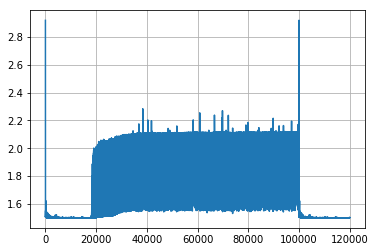

Wall time: 6.56 s


In [25]:
%%time
perchik = Perceptron(28 * 28, 16, 16, 10, False)
perchik.teach_stochastic(2)